In [41]:
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import qutip as qtp
%matplotlib inline
%matplotlib widget 
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

**Jaynes Cummings Model**

This will serve as an initial approach to qutip simulations. Following the Jaynes Cummings lecture. We will use units such that $\hbar$ =1

Our first step will be defining the parameters present in our Hamiltonian. We must remember that in this model we have an atom that can be in two levels, either the ground state or the excited state; and a single-mode cavity field.

The constants we first want to define are the field frequency, the atom frequency (defined by the difference of energies between the states) and the coupling  strength between these systems.

In [42]:
wc=2*np.pi #cavity
wa=2*np.pi #atom 
g= 0.05 * 2 * np.pi #coupling strength

kappa=0.005 #cavity dissipation rate
gamma=0.05 #atom dissipation rate
nth=0.0 #average number of thermal photons 

N=100 #Number of cavity Fock States (we can try different values but one must have in mind that a bigger Hilbert state will be slower in calculations (Though more formally correct))
tlist= np.linspace(0,25,501) #times at which we will run our simulation

Once we have set our constants we have to write our Hamiltonian. I will directly work with the rotating wave approximation which simplifies the expression.
$
\begin{equation}
H_{RWA}=\frac{1}{2}\hbar \omega_{a} \sigma_{3}+\hbar \omega_{c} a^{\dagger} a + \hbar g (\sigma_{+}a+\sigma_{-}a^{\dagger})
\end{equation}
$

Note that we had decided to use units such that $\hbar$ =1

In [43]:
#INITIAL STATE will be an excited atom in the cavity in the vacuum state
psi_i=qtp.tensor(qtp.basis(N,0),qtp.basis(2,1))
#We also will define the operators to work more confortably
a=qtp.tensor(qtp.destroy(N),qtp.qeye(2))
sm=qtp.tensor(qtp.qeye(N),qtp.destroy(2))
#hamiltonian 
H=wc*a.dag()*a+wa*sm.dag()*sm+g+(a*sm.dag()+a.dag()*sm) #NO ENTIENDO MUY BIEN ESTA DEFINICIÓN DE SIGMA3, NO FALTA -gketgbra??

We also have to create a list of operators to describe dissipation, this is because the mesolve function in qutip requires a Hamiltonian, an initial state, a time list and a collapse operator or a list of these to describe the dissipation in our system.

In [44]:
collapse=[]

#cavity relaxation
rate=kappa*(1+nth)
if rate>0.0:
    collapse.append(np.sqrt(rate)*a)
#cavity excitation
rate=kappa*nth
if rate>0.0:
    collapse.append(np.sqrt(rate)*a.dag())
#atom decay (excited to ground)
rate=gamma
if rate>0.0:
    collapse.append(np.sqrt(rate)*sm)

Once we have all these set, we evolve the system with the **mesolve** tool from qutip. We will give it a list of observables that we want it to return after the calculations

In [45]:
obs= [a.dag()*a,sm.dag()*sm]
results=qtp.mesolve(H,psi_i,tlist,collapse,obs)
nc=results.expect[0]
na=results.expect[1]

Once we have calculated the expectation value of our observables, we may want to represent them to analyze the results

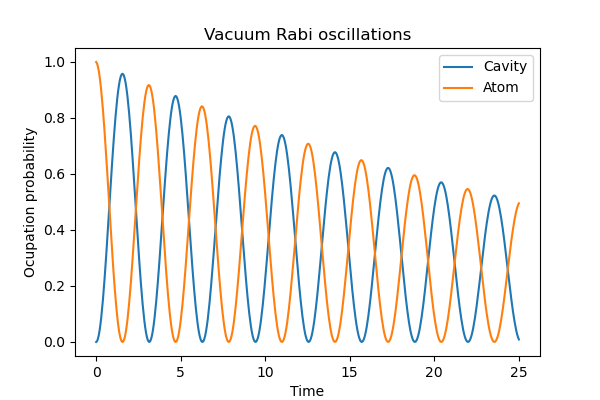

In [46]:
vac = plt.figure(figsize=(6, 4))
plt.title("Vacuum Rabi oscillations")
plt.plot(tlist,nc,tlist,na)
plt.xlabel("Time")
plt.ylabel("Ocupation probability")
plt.legend(["Cavity","Atom"])

In [47]:
psinew=qtp.tensor(qtp.coherent(N,np.sqrt(5)),qtp.basis(2,1))
obscoh= [a.dag()*a,sm.dag()*sm]
resultscoh=qtp.mesolve(H,psinew,tlist,collapse,obs)
nccoh=resultscoh.expect[0]
nacoh=resultscoh.expect[1]

Now I will try to reproduce the results for an external field in a coherent state with $\bar{n}$ =5

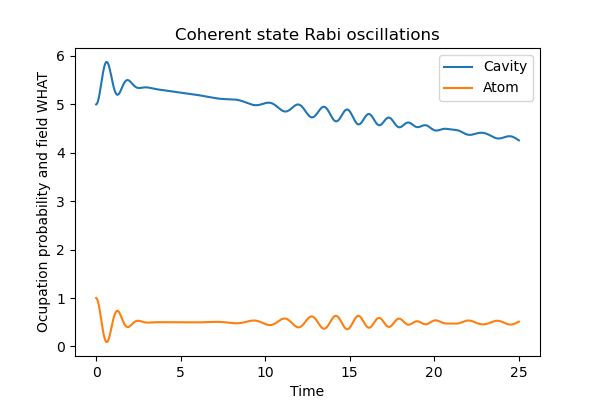

In [48]:
coh = plt.figure(figsize=(6, 4))
plt.title("Coherent state Rabi oscillations")
plt.plot(tlist,nccoh,tlist,nacoh)
plt.xlabel("Time")
plt.ylabel("Ocupation probability and field WHAT")
plt.legend(["Cavity","Atom"])

In a very interesting result, we observe that the probability of the state being in the excited state experiments the studied phenomenon of the **revivals** where the amplitude dies down and comes back after a certain time

In [49]:
alpha=np.sqrt(5)
D1=qtp.displace(N,alpha)
D2=qtp.displace(N,-alpha)
xvec = np.arange(-10,10, 1e-1)
yvec = xvec
norm=1/(np.sqrt(2*(1+np.exp(-2*(alpha*alpha)))))
state=norm*(D1+D2) *qtp.basis(N,0)
psi_e=qtp.tensor(state,qtp.basis(2,1))
resultscat=qtp.mesolve(H,psi_e,tlist,collapse,[])

In [127]:
# find the indices of the density matrices for the times we are interested in
t_idx = np.where([tlist == t for t in [0.0, 0.5, 1.0, 2.0, 25.0]])[1]
tlist[t_idx]
# get a list density matrices
rho_list = [resultscat.states[i] for i in t_idx]
wigres=[]
for i in range(len(rho_list)):
    rho_cav=qtp.ptrace(rho_list[i],0)
    wigres.append(qtp.wigner(rho_cav,xvec,yvec))

Text(0.5, 1.0, 'Even cat state Wigner Function with Qutip for N=100 in t=0.0')

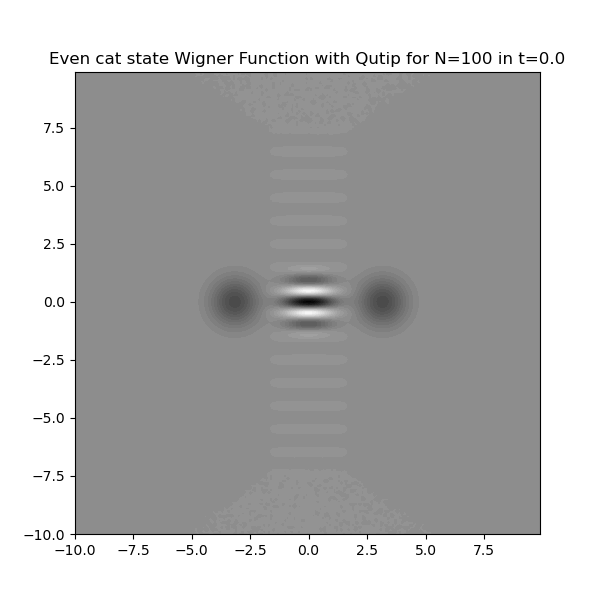

In [133]:
XYLI=10
X, Y = np.meshgrid(xvec, yvec)
fig = plt.figure(figsize=(6, 6)) 
plt.contourf(X, Y, wigres[0], 50, cmap=mpl.colormaps['binary'])
plt.title("Even cat state Wigner Function with Qutip for N=100 in t="+str(tlist[t_idx[0]]))

Text(0.5, 1.0, 'Even cat state Wigner Function with Qutip for N=100 in t=0.5')

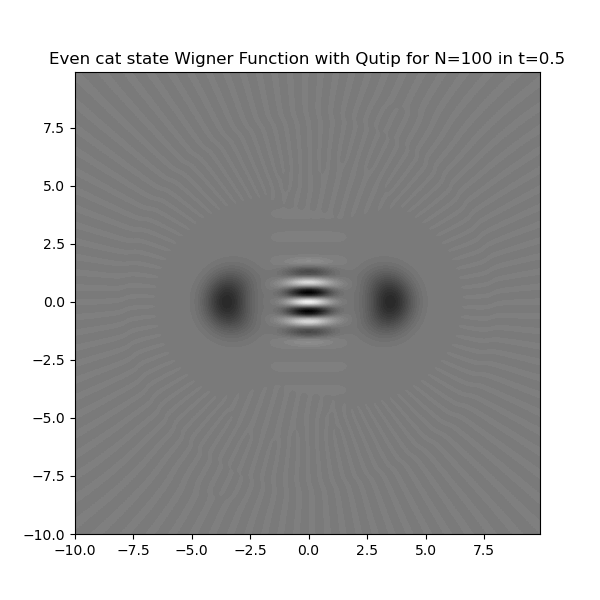

In [134]:
fig = plt.figure(figsize=(6, 6)) 
plt.contourf(X, Y, wigres[1], 50, cmap=mpl.colormaps['binary'])
plt.title("Even cat state Wigner Function with Qutip for N=100 in t="+str(tlist[t_idx[1]]))

Text(0.5, 1.0, 'Even cat state Wigner Function with Qutip for N=100 in t=1.0')

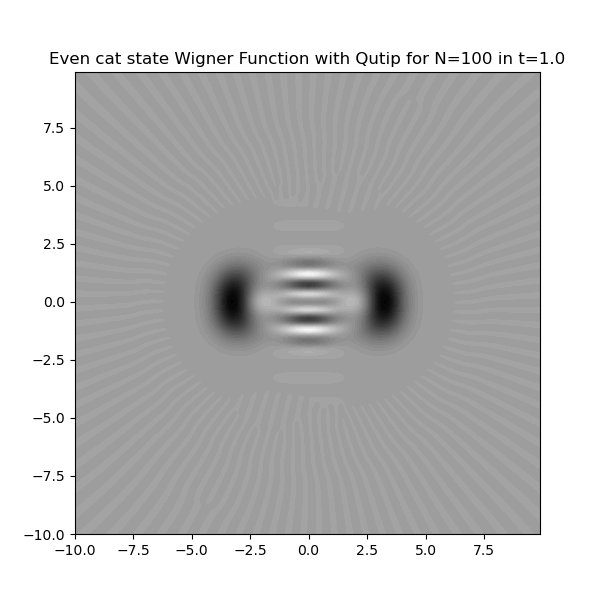

In [135]:
fig = plt.figure(figsize=(6, 6)) 
plt.contourf(X, Y, wigres[2], 50, cmap=mpl.colormaps['binary'])
plt.title("Even cat state Wigner Function with Qutip for N=100 in t="+str(tlist[t_idx[2]]))

Text(0.5, 1.0, 'Even cat state Wigner Function with Qutip for N=100 in t=2.0')

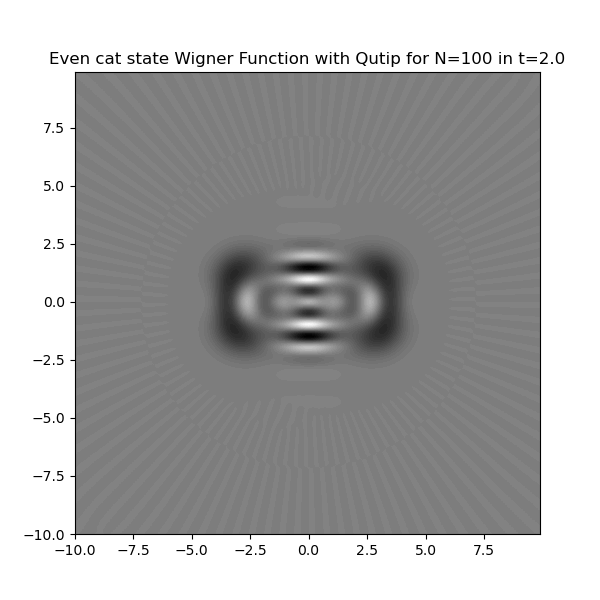

In [136]:
fig = plt.figure(figsize=(6, 6)) 
plt.contourf(X, Y, wigres[3], 50, cmap=mpl.colormaps['binary'])
plt.title("Even cat state Wigner Function with Qutip for N=100 in t="+str(tlist[t_idx[3]]))

Text(0.5, 1.0, 'Even cat state Wigner Function with Qutip for N=100 in t=25.0')

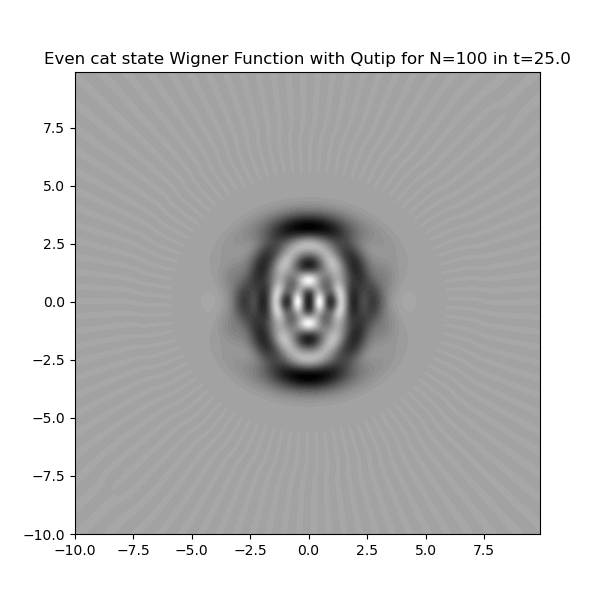

In [137]:
fig = plt.figure(figsize=(6, 6)) 
plt.contourf(X, Y, wigres[4], 50, cmap=mpl.colormaps['binary'])
plt.title("Even cat state Wigner Function with Qutip for N=100 in t="+str(tlist[t_idx[4]]))

In [113]:
mpl.pyplot.close(fig = plt.figure(figsize=(4, 3)))

I was not sure about the definition used for the Hamiltonian in our first calculations so I wil try something to see if the results are changed in any way

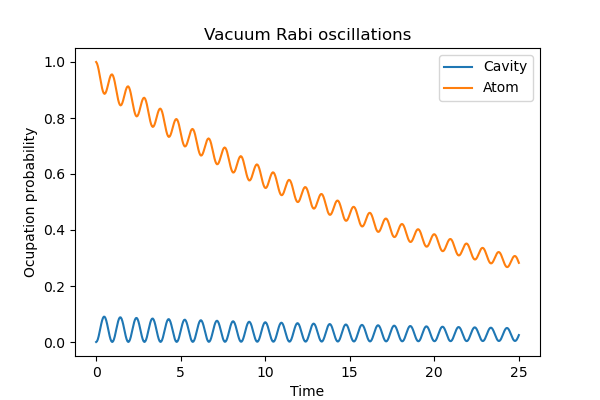

In [139]:
H=wc*a.dag()*a+wa*(sm.dag()*sm-sm*sm.dag())+g+(a*sm.dag()+a.dag()*sm) #NO ENTIENDO MUY BIEN ESTA DEFINICIÓN DE SIGMA3, NO FALTA -gketgbra??
obs= [a.dag()*a,sm.dag()*sm]
results=qtp.mesolve(H,psi_i,tlist,collapse,obs)
nc=results.expect[0]
na=results.expect[1]
vac = plt.figure(figsize=(6, 4))
plt.title("Vacuum Rabi oscillations")
plt.plot(tlist,nc,tlist,na)
plt.xlabel("Time")
plt.ylabel("Ocupation probability")
plt.legend(["Cavity","Atom"])

Indeed, they are. In the first Hamiltonian we have ignored the part involving the Ground states in the inversion operator. Is it because we are just examining the results for the population evolution of the excited level? We had defined 
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\newcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\sigma_{3}=\ket{e}\bra{e}-\ket{g}\bra{g}$$

Wich satisfied the commutation relation: $[\sigma_{+},\sigma_{-}]=\sigma_{3}$

However, considering we have defined **sm** to be the $\sigma_{-}$ we have only included half of the $\sigma_{3}$ expression in our hamiltonian. The figure above is the result I have obtained for a Hamiltonian that included this term. 

**What is happening?**